In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

# preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer

# validation
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, cross_val_score

# valuation
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# modeling
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
%matplotlib inline

# etc 
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
df = pd.read_csv("C:/Users/kshee/Desktop/방학스터디 데이터/diversified_ecommerce_dataset.csv")

In [3]:
df.head()

,Product ID,Product Name,Category,Price,Discount,Tax Rate,Stock Level,Supplier ID,Customer Age Group,Customer Location,Customer Gender,Shipping Cost,Shipping Method,Return Rate,Seasonality,Popularity Index
0,P6879,Jacket,Apparel,53.85,5,15,150,S535,35-44,"New York, USA",Male,23.32,Standard,4.49,Yes,56
1,P5132,Camera,Electronics,761.26,10,15,224,S583,25-34,"London, UK",Female,20.88,Overnight,16.11,No,79
2,P2941,Sneakers,Footwear,1756.76,5,8,468,S118,25-34,"Tokyo, Japan",Non-Binary,16.43,Standard,4.93,No,40
3,P8545,Cookbooks,Books,295.24,10,15,25,S104,18-24,"Paris, France",Female,27.49,Standard,1.31,No,93
4,P4594,Camera,Electronics,832.00,10,12,340,S331,55+,"Tokyo, Japan",Male,45.93,Overnight,4.37,No,56


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 16 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Product ID          1000000 non-null  object 
 1   Product Name        1000000 non-null  object 
 2   Category            1000000 non-null  object 
 3   Price               1000000 non-null  float64
 4   Discount            1000000 non-null  int64  
 5   Tax Rate            1000000 non-null  int64  
 6   Stock Level         1000000 non-null  int64  
 7   Supplier ID         1000000 non-null  object 
 8   Customer Age Group  1000000 non-null  object 
 9   Customer Location   1000000 non-null  object 
 10  Customer Gender     1000000 non-null  object 
 11  Shipping Cost       1000000 non-null  float64
 12  Shipping Method     1000000 non-null  object 
 13  Return Rate         1000000 non-null  float64
 14  Seasonality         1000000 non-null  object 
 15  Popularity Index

In [5]:
df.isna().sum()

Product ID            0
Product Name          0
Category              0
Price                 0
Discount              0
Tax Rate              0
Stock Level           0
Supplier ID           0
Customer Age Group    0
Customer Location     0
Customer Gender       0
Shipping Cost         0
Shipping Method       0
Return Rate           0
Seasonality           0
Popularity Index      0
dtype: int64

In [6]:
df.describe()

,Price,Discount,Tax Rate,Stock Level,Shipping Cost,Return Rate,Popularity Index
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,1005.120742,12.516955,10.002052,250.028536,24.985224,10.492896,49.970211
std,574.451223,8.539929,3.406026,144.676275,14.431730,5.484849,29.164875
min,10.000000,0.000000,5.000000,0.000000,0.000000,1.000000,0.000000
25%,507.860000,5.000000,8.000000,125.000000,12.490000,5.740000,25.000000
50%,1005.430000,15.000000,10.000000,250.000000,24.970000,10.480000,50.000000
75%,1502.310000,20.000000,12.000000,375.000000,37.470000,15.250000,75.000000
max,2000.000000,25.000000,15.000000,500.000000,50.000000,20.000000,100.000000


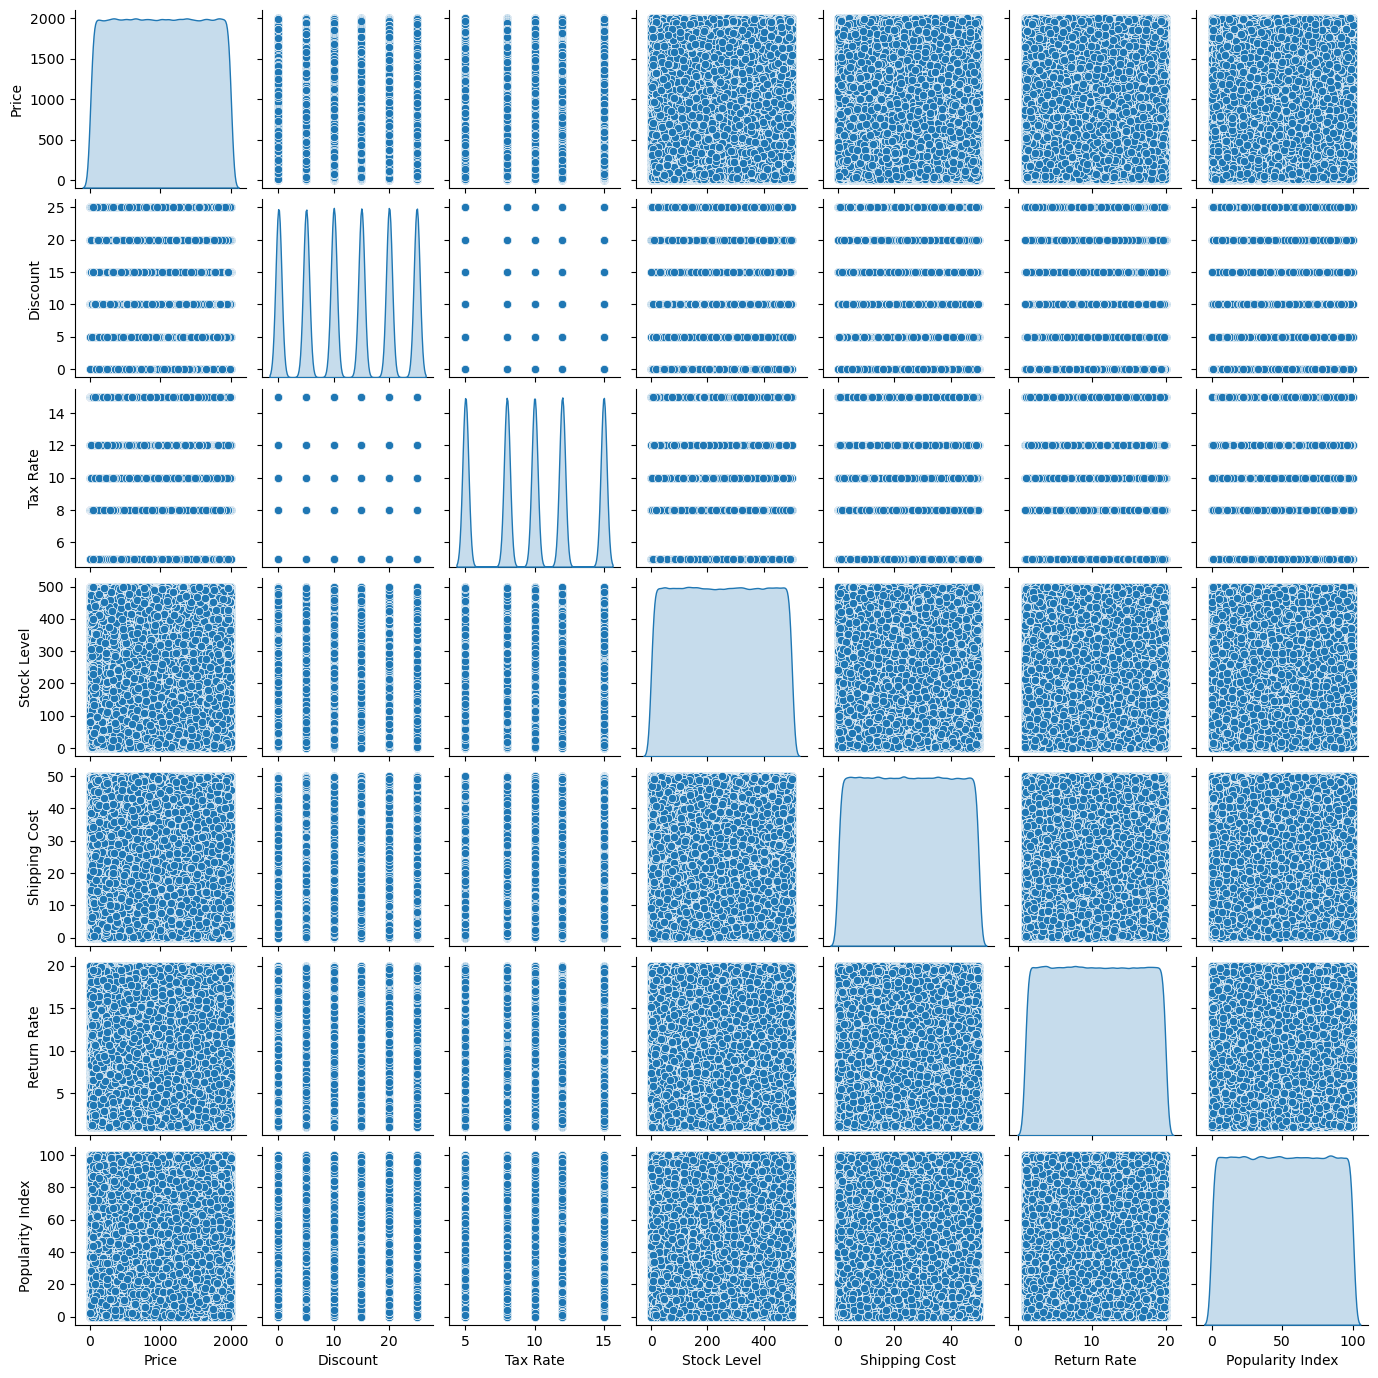

In [28]:
#숫자형 데이터 산점도로 시각화히기
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
sns.pairplot(df[numeric_columns], height=2, diag_kind='kde')
plt.show()

In [30]:
numeric_df = df.select_dtypes(include='number')
correlation_matrix = numeric_df.corr()
print(correlation_matrix)

                     Price  Discount  Tax Rate  Stock Level  Shipping Cost  \
Price             1.000000  0.000137 -0.000357     0.000213      -0.001758   
Discount          0.000137  1.000000  0.001209     0.000425       0.001071   
Tax Rate         -0.000357  0.001209  1.000000     0.001220      -0.000610   
Stock Level       0.000213  0.000425  0.001220     1.000000      -0.000811   
Shipping Cost    -0.001758  0.001071 -0.000610    -0.000811       1.000000   
Return Rate      -0.000405  0.000381 -0.001154    -0.000190      -0.000090   
Popularity Index -0.000233  0.001250  0.000660     0.000303       0.000519   

                  Return Rate  Popularity Index  
Price               -0.000405         -0.000233  
Discount             0.000381          0.001250  
Tax Rate            -0.001154          0.000660  
Stock Level         -0.000190          0.000303  
Shipping Cost       -0.000090          0.000519  
Return Rate          1.000000          0.001648  
Popularity Index     0.00

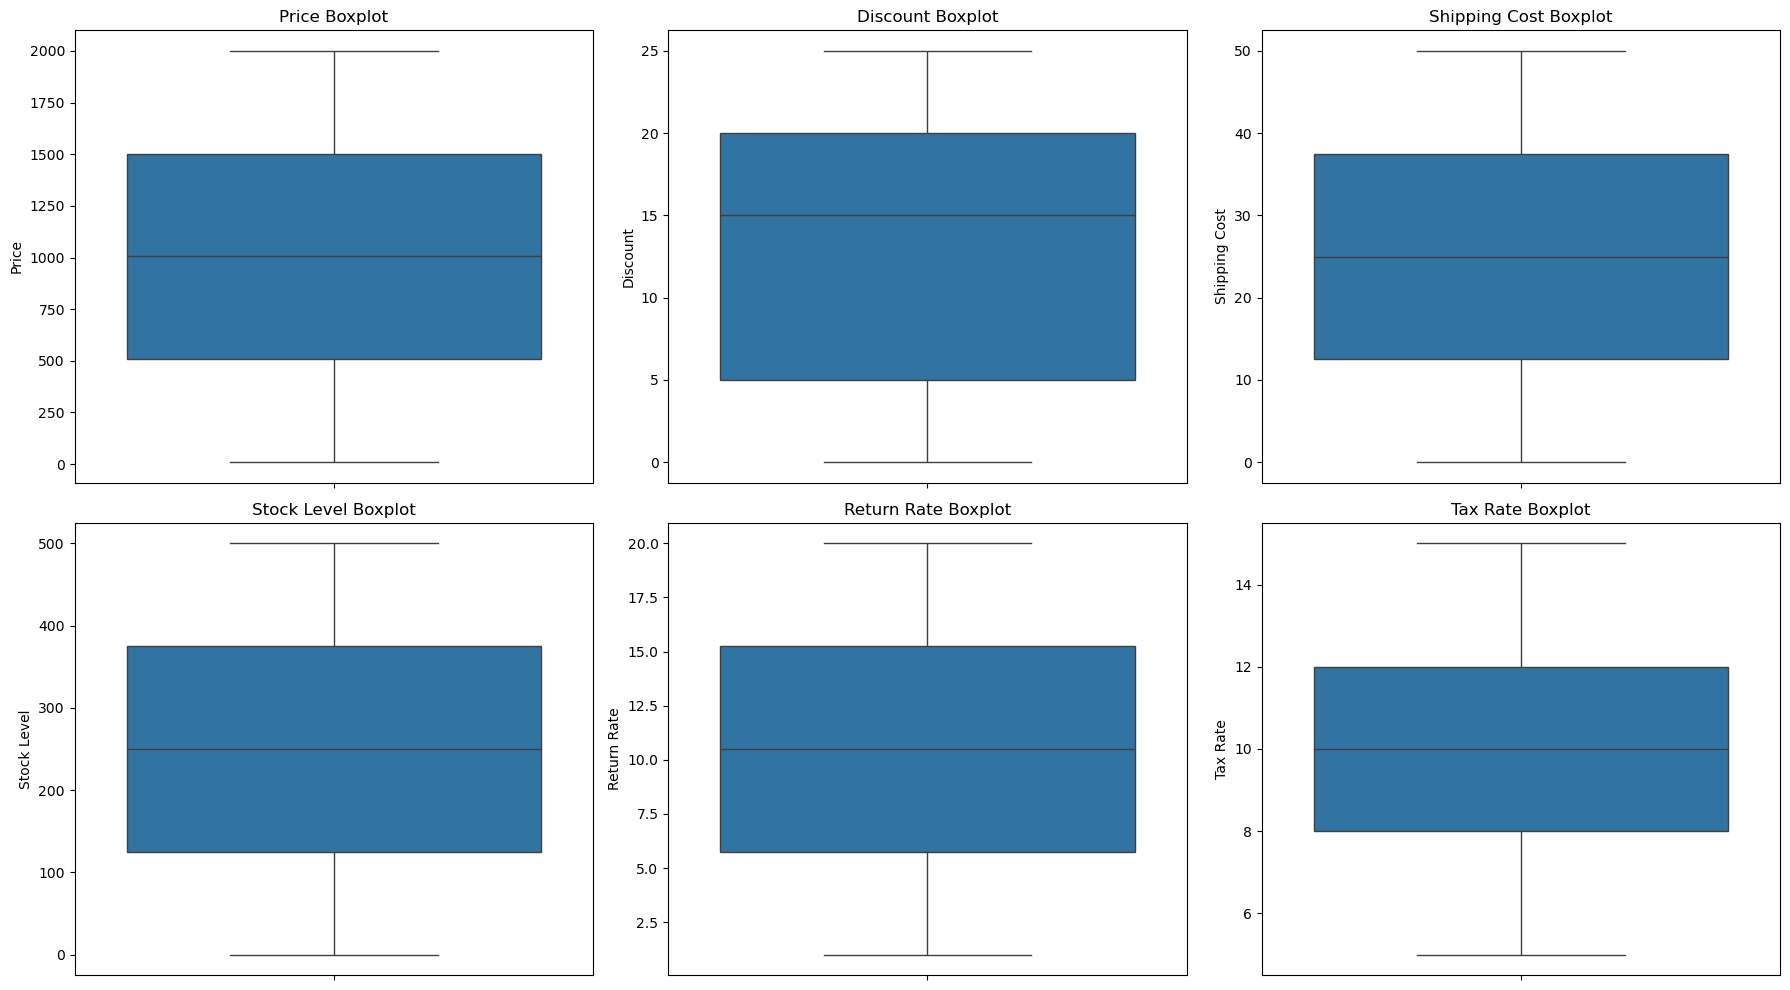

In [50]:
# 변수 리스트
columns = ['Price', 'Discount', 'Shipping Cost', 'Stock Level', 'Return Rate', 'Tax Rate']

# 서브플롯 생성
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2행 3열 서브플롯

# 각 변수에 대해 박스플롯 생성
for i, col in enumerate(columns):
    row = i // 3  # 행
    col_index = i % 3  # 열
    sns.boxplot(data=df, y=col, ax=axes[row, col_index])
    axes[row, col_index].set_title(f'{col} Boxplot')

# 간격 조정
plt.tight_layout()
plt.show()
